In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.decomposition import PCA
import joblib

In [62]:
# Load the dataset
data = pd.read_csv('actualDataset.csv')

In [63]:
data = data[['created_at','field1', 'field2', 'field3']]

In [64]:
# Display basic info
data.shape

(5243, 4)

In [65]:
data.head()

,created_at,field1,field2,field3
0,2024-05-11T06:18:07+00:00,0,1075898172,9742691
1,2024-05-11T06:18:32+00:00,0,0,0
2,2024-05-11T06:19:01+00:00,0,0,26213679
3,2024-05-11T06:19:20+00:00,32767,-3024,31764034
4,2024-05-11T06:19:37+00:00,32767,-2668,37096834


In [66]:
data.sample(5)

,created_at,field1,field2,field3
3720,2024-05-13T15:04:23+00:00,299,0,0
3051,2024-05-12T15:16:59+00:00,364,474,32767
1327,2024-05-13T17:46:07+00:00,0,0,0
3602,2024-05-13T07:56:42+00:00,4,-6840,-7168
2913,2024-05-12T14:26:21+00:00,402,32767,4204


In [67]:
# Convert 'created_at' to datetime
data['created_at'] = pd.to_datetime(data['created_at'])
print(data.head())

                 created_at  field1      field2    field3
0 2024-05-11 06:18:07+00:00       0  1075898172   9742691
1 2024-05-11 06:18:32+00:00       0           0         0
2 2024-05-11 06:19:01+00:00       0           0  26213679
3 2024-05-11 06:19:20+00:00   32767       -3024  31764034
4 2024-05-11 06:19:37+00:00   32767       -2668  37096834


In [68]:
# Normalize the sensor values
scaler = StandardScaler()
data[['field1', 'field2', 'field3']] = scaler.fit_transform(data[['field1', 'field2', 'field3']])

In [69]:
data.head()

,created_at,field1,field2,field3
0,2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
1,2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2,2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
3,2024-05-11 06:19:20+00:00,-0.419554,-0.469221,-0.422007
4,2024-05-11 06:19:37+00:00,-0.419554,-0.469220,-0.401637


In [70]:
data.describe()

,field1,field2,field3
count,5.243000e+03,5243.000000,5.243000e+03
mean,4.336709e-17,0.000000,-4.336709e-17
std,1.000095e+00,1.000095,1.000095e+00
min,-4.197182e-01,-0.469287,-5.434498e-01
25%,-4.196394e-01,-0.469213,-5.433344e-01
50%,-4.196392e-01,-0.469213,-5.432820e-01
75%,-4.195859e-01,-0.469166,1.310815e-01
max,2.383061e+00,2.136566,4.311554e+00


In [71]:
# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [72]:
# Segment the data into time windows (e.g., 1-second windows)
data.set_index('created_at', inplace=True)
windowed_data = data.resample('1S').mean().dropna()

In [73]:
data.head()

,field1,field2,field3
created_at,,,
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
2024-05-11 06:19:20+00:00,-0.419554,-0.469221,-0.422007
2024-05-11 06:19:37+00:00,-0.419554,-0.469220,-0.401637


In [74]:
windowed_data

,field1,field2,field3
created_at,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333


In [76]:
def extract_features(window):
    mean_vals = window.mean(axis=0)
    std_vals = window.std(axis=0)
    max_vals = window.max(axis=0)
    min_vals = window.min(axis=0)
    
    # Handle cases where scalar values are returned
    if isinstance(mean_vals, float):
        mean_vals = np.array([mean_vals])
    if isinstance(std_vals, float):
        std_vals = np.array([std_vals])
    if isinstance(max_vals, float):
        max_vals = np.array([max_vals])
    if isinstance(min_vals, float):
        min_vals = np.array([min_vals])

    print("mean_vals shape:", mean_vals.shape)
    print("std_vals shape:", std_vals.shape)
    print("max_vals shape:", max_vals.shape)
    print("min_vals shape:", min_vals.shape)
    
    return np.concatenate([mean_vals, std_vals, max_vals, min_vals])
    
features = windowed_data.apply(extract_features, axis=1).tolist()
X = np.array(features)

mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
min_vals shape: (1,)
mean_vals shape: (1,)
std_vals shape: (1,)
max_vals shape: (1,)
m

## PCA

In [77]:
# PCA for visualizing clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [78]:
pca

PCA(n_components=2)

In [79]:
X_pca

array([[ 3.60160549,  2.1412487 ],
       [ 1.82029013, -0.36091301],
       [-1.21874546,  0.01002801],
       ...,
       [-1.21874494,  0.01002851],
       [-1.21874594,  0.0100275 ],
       [-1.21874484,  0.01002847]])

In [80]:
# Function to plot cluster results
def plot_clusters(X, labels, algorithm_name):
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_data = X[labels == label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Clusters visualization using {algorithm_name}')
    plt.legend()
    plt.show()

In [81]:
windowed_data

,field1,field2,field3
created_at,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333


## KMeans Clustering

C:\Users\saman\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


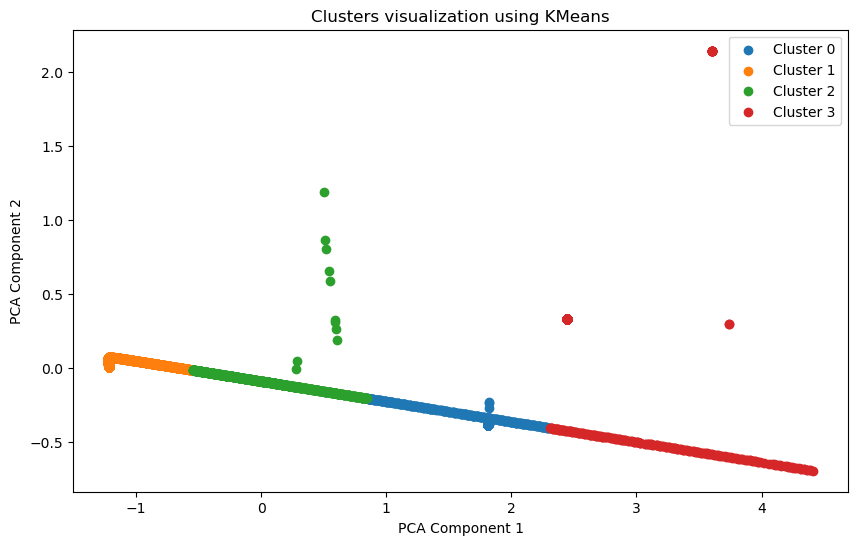

Silhouette Score for KMeans: 0.7401435019519216


In [82]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
plot_clusters(X_pca, kmeans_labels, 'KMeans')
print(f'Silhouette Score for KMeans: {silhouette_score(X, kmeans_labels)}')

## DBSCAN Clustering

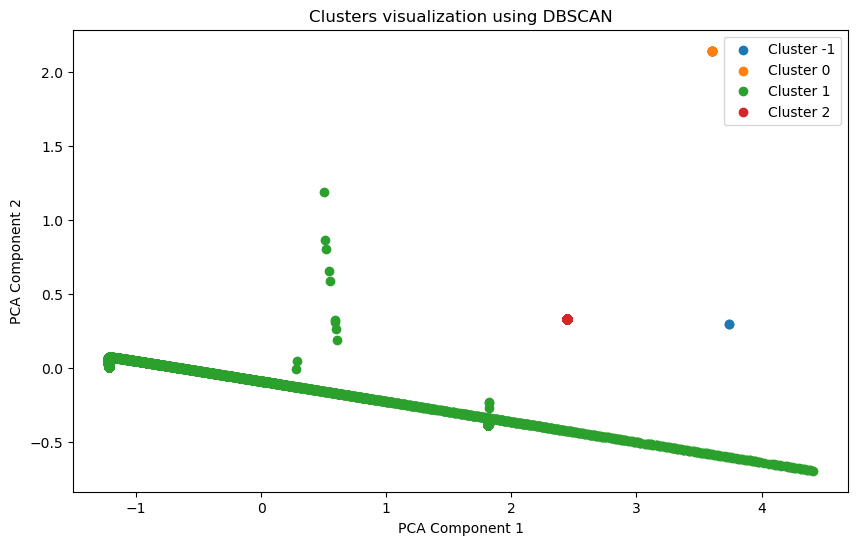

Silhouette Score for DBSCAN: 0.5850441098603394


In [83]:
# DBSCAN Clustering (Tuning parameters skipped for brevity)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
plot_clusters(X_pca, dbscan_labels, 'DBSCAN')
print(f'Silhouette Score for DBSCAN: {silhouette_score(X, dbscan_labels)}')

In [84]:
windowed_data

,field1,field2,field3
created_at,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333


##  Agglomerative Clustering

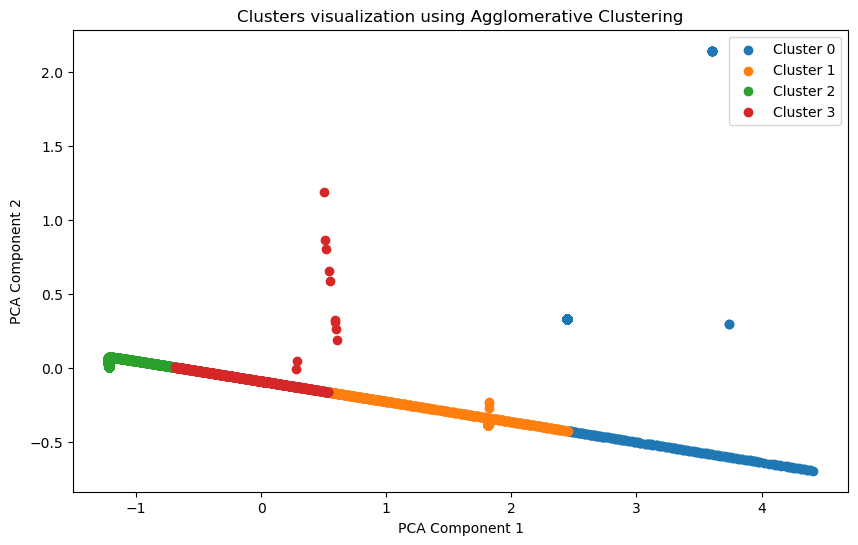

Silhouette Score for Agglomerative Clustering: 0.7362060397908078


In [85]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X)
plot_clusters(X_pca, agglo_labels, 'Agglomerative Clustering')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_score(X, agglo_labels)}')

In [86]:
windowed_data

,field1,field2,field3
created_at,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207
...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333


In [87]:
# Adding cluster labels to the windowed data
windowed_data['kmeans_cluster'] = kmeans_labels
windowed_data['dbscan_cluster'] = dbscan_labels
windowed_data['agglo_cluster'] = agglo_labels

In [88]:
windowed_data

,field1,field2,field3,kmeans_cluster,dbscan_cluster,agglo_cluster
created_at,,,,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036,3,0,0
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121,0,1,1
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334,1,1,2
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333,1,1,2
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207,1,1,2
...,...,...,...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333,1,1,2
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334,1,1,2
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333,1,1,2


In [89]:
# Prepare the features and labels for classification
# Manually inspect and label clusters if necessary
# Example:
cluster_labels = {0: 'running', 1: 'walking', 2: 'other', 3: 'fetal movement'}
windowed_data['activity'] = windowed_data['kmeans_cluster'].map(cluster_labels)

In [90]:
windowed_data

,field1,field2,field3,kmeans_cluster,dbscan_cluster,agglo_cluster,activity
created_at,,,,,,,
2024-05-11 06:18:05+00:00,2.383061,2.131172,3.566036,3,0,0,fetal movement
2024-05-11 06:18:07+00:00,-0.419639,2.136566,-0.506121,0,1,1,running
2024-05-11 06:18:32+00:00,-0.419639,-0.469213,-0.543334,1,1,2,walking
2024-05-11 06:19:00+00:00,-0.419638,-0.469213,-0.543333,1,1,2,walking
2024-05-11 06:19:01+00:00,-0.419639,-0.469213,-0.443207,1,1,2,walking
...,...,...,...,...,...,...,...
2024-05-23 14:58:55+00:00,-0.419638,-0.469213,-0.543333,1,1,2,walking
2024-05-23 14:59:10+00:00,-0.419639,-0.469213,-0.543334,1,1,2,walking
2024-05-23 14:59:16+00:00,-0.419638,-0.469213,-0.543333,1,1,2,walking


In [91]:
# Split data into training and testing sets
y = windowed_data['activity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Function to evaluate classification results
def evaluate_classifier(clf, X_train, X_test, y_train, y_test, algorithm_name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {algorithm_name}: {accuracy}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {algorithm_name}')
    plt.show()

    return clf

Accuracy for RandomForest: 0.9990403071017274


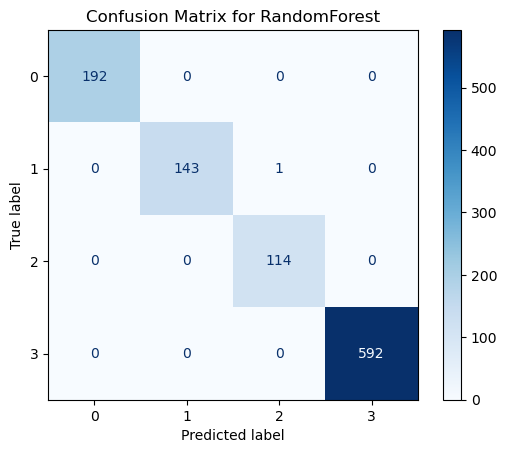

In [93]:
# RandomForest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf = evaluate_classifier(rf_clf, X_train, X_test, y_train, y_test, 'RandomForest')

In [94]:
# Export the RandomForest model
joblib.dump(rf_clf, 'random_forest_model.pkl')

['random_forest_model.pkl']